---
**Turma**: 15

**Grupo**: 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`

**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

### Objetivo:

 Qual a recomendação do ifood para o próximo pedido do cliente? É possível predizer o próximo pedido? 

### Etapas:

1) Carregar ABT (analytical base table) e importar tabelas

2) Separando a abt em treino e teste

3) Modelagem com decision tree

4) Avaliação do modelo

5) Tuning de hiperparametros

### 1) Carregando Analytical base table

In [0]:
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import pandas as pd

root_dir = '/dbfs/FileStore/ifood'
dbutils.fs.ls(f'{root_dir}')

treino = spark.read.parquet(f'{root_dir}/abt/abt_treino')
teste =  spark.read.parquet(f'{root_dir}/abt/abt_teste')

##### Tratando missing

In [0]:
treino = treino.fillna(0)
teste = teste.fillna(0)

#### 2) Aplicando vector assembler na base de treino e teste

In [0]:
#vector assembler
assembler = VectorAssembler(
    inputCols = treino.drop('merchant_dish_type').columns,
     outputCol = 'features'
)

treino = assembler.transform(treino)
teste = assembler.transform(teste)

In [0]:
#string index na classe
indexer = StringIndexer(inputCol="merchant_dish_type", outputCol="merchant_dish_type_index")

treino = indexer.fit(treino).transform(treino)
teste = indexer.fit(teste).transform(teste)

#### 4)  Verificando a distribuição das classes na base de treino e teste

In [0]:
display(treino.groupby('merchant_dish_type').count())

merchant_dish_type,count
Comida Brasileira,67178
Pizza,62820
Lanches,108007
outros,128301


In [0]:
display(teste.groupby('merchant_dish_type').count())

merchant_dish_type,count
Comida Brasileira,28507
Pizza,26787
Lanches,46496
outros,55304


#### 4) Modelagem

##### Baseline

Caso fosse chutado em todos os pedidos que a recomendação seria o prato mais frequente da base (outros), teriamos um percentual de acerto igual a 35,20%

In [0]:
tot = teste.count()

teste.groupBy("merchant_dish_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .show()

+------------------+-------------+-------------------+
merchant_dish_type|cnt_per_group|perc_of_count_total|
+------------------+-------------+-------------------+
 Comida Brasileira| 28507| 18.146460081225253|
 Pizza| 26787| 17.051574216711014|
 Lanches| 46496| 29.597565788636103|
 outros| 55304| 35.20439991342763|
+------------------+-------------+-------------------+

#### Decision Tree

In [0]:
treino.cache()
teste.cache()

Out[8]: DataFrame[merchant_dish_type: string, promo_items_quantity: double, hora_pedido: bigint, mes_pedido: bigint, paid_amount: double, lunch: bigint, lanche_1_freq: int, pizza_1_freq: int, comida_brasileira_1_freq: int, outros_1_freq: int, features: vector, merchant_dish_type_index: double]

In [0]:
#definindo hiperparametros
decisionTree = DecisionTreeClassifier(
  featuresCol='features',
  labelCol='merchant_dish_type_index'
)

#treinando árvore de decisão
dc = decisionTree.fit(treino)

In [0]:
%sh
pip install pydotplus
sudo apt-get install -y graphviz

Collecting pydotplus
 Downloading https://files.pythonhosted.org/packages/60/bf/62567830b700d9f6930e9ab6831d6ba256f7b0b730acb37278b0ccdffacf/pydotplus-2.0.2.tar.gz (278kB)
Requirement already satisfied: pyparsing>=2.0.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pydotplus) (2.3.1)
Building wheels for collected packages: pydotplus
 Building wheel for pydotplus (setup.py): started
 Building wheel for pydotplus (setup.py): finished with status 'done'
 Stored in directory: /root/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
Installing collected packages: pydotplus
Successfully installed pydotplus-2.0.2
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
 libgnutls-openssl27
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
 fonts-liberation libcdt5 libcgraph6 libgvc6 libgvpr2 libpathplan4
Suggested packages:
 graphviz-doc
The following NEW packages will be installed:
 fonts-liberation graphviz libcdt5 libcgraph6 libgvc6 libgvpr2 libpathplan4
0 upgraded, 7 newly installed, 0 to remove and 0 not upgraded.
Need to get 2,364 kB of archives.
After this operation, 14.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu xenial/main amd64 fonts-liberation all 1.07.4-1 [829 kB]
Get:2 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libcdt5 amd64 2.38.0-12ubuntu2.1 [23.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libcgraph6 amd64 2.38.0-12ubuntu2.1 [43.6 kB]
Get:4 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libpathplan4 amd64 2.38.0-12ubuntu2.1 [26.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgvc6 amd64 2.38.0-12ubuntu2.1 [591 kB]
Get:6 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgvpr2 amd64 2.38.0-12ubuntu2.1 [170 kB]
Get:7 http://archive.ubuntu.com/ubuntu xenial-updates/main amd64 graphviz amd64 2.38.0-12ubuntu2.1 [680 kB]
debconf: delaying package configuration, since apt-utils is not installed
Fetched 2,364 kB in 1s (1,527 kB/s)
Selecting previously unselected package fonts-liberation.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%
(Reading database ... 55%
(Reading database ... 60%
(Reading database ... 65%
(Reading database ... 70%
(Reading database ... 75%
(Reading database ... 80%
(Reading database ... 85%
(Reading database ... 90%
(Reading database ... 95%
(Reading database ... 100%
(Reading database ... 61805 files and directories currently installed.)
Preparing to unpack .../fonts-liberation_1.07.4-1_all.deb ...
Unpacking fonts-liberation (1.07.4-1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../libcdt5_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libcdt5 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../libcgraph6_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libcgraph6 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libpathplan4.
Preparing to unpack .../libpathplan4_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libpathplan4 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libgvc6.
Preparing to unpack .../libgvc6_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libgvc6 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package libgvpr2.
Preparing to unpack .../libgvpr2_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking libgvpr2 (2.38.0-12ubuntu2.1) ...
Selecting previously unselected package graphviz.
Preparing to unpack .../graphviz_2.38.0-12ubuntu2.1_amd64.deb ...
Unpacking graphviz (2.38.0-12ubuntu2.1) ...
Processing triggers for fontco

In [0]:
from spark_tree_plotting import export_graphviz

dot_data = export_graphviz(
  dc,
  featureNames=treino.drop('merchant_dish_type').columns,
  classNames=['Lanches', 'Comida Brasileira', 'Pizza', 'outros'],
  filled=True,
  roundedCorners=True,
  roundLeaves=True
)

In [0]:
help(export_graphviz)

Help on function export_graphviz in module spark_tree_plotting:

export_graphviz(DecisionTreeClassificationModel, featureNames=None, categoryNames=None, classNames=None, filled=True, roundedCorners=True, roundLeaves=True)
 Generates a DOT string out of a Spark's fitted DecisionTreeClassificationModel, which
 can be drawn with any library capable of handling the DOT format.
 
 If you want to plot in a single step, please use the function plot_tree().
 
 Arguments:
 DecisionTreeClassificationModel -- a pyspark.ml.classification.DecisionTreeClassificationModel
 instance
 
 featureNames -- a list with the feature names. This
 is probably the same list you usually
 pass to your VectorAssembler constructor
 
 categoryNames -- a dictionary with the featureNames that
 are categorical as the keys, and the
 different categories as the values.
 This is probably the featureNames as key,
 StringIndexerModel.labels attribute as value
 for each categorical feature
 
 classNames -- a list with the class names for your target
 column. This is probably the StringIndexerModel.labels
 for your target column
 
 filled -- boolean which indicates whether to fill nodes with colour
 or not. Color gamma will be the prediction class for each
 node, and color intensity the impurity at such node
 
 roundedCorners -- boolean which indicates whether to round 
 rectangle corners for the nodes
 
 roundLeaves -- boolean which indicates whether to represent leaf
 nodes as ellipses rather than rectangles
 
 Returns:
 a DOT string ready to be processed by any DOT handling library

In [0]:
import pydotplus

# Converte o modelo de arvore gerado para imagem
imagem = pydotplus.graph_from_dot_data(dot_data)

# Para visualizar será necessário armazenar a imagem no DBFS
imagem.write_png('/dbfs/FileStore/arvore_decisao.png')


Out[12]: True

Para visualizar o código que carrega a imagem, clique duas vezes nessa cédula.

<img src="files/arvore_decisao.png" >

#### 5) Avaliando decision tree

In [0]:
from sklearn.metrics import classification_report 
#aplicando o predict na base de teste
dfPrediction = dc.transform(teste)


pd.set_option('display.precision', 6)

#criando tabela auxiliar para utilização do classification_report
dfReport = dfPrediction.select('merchant_dish_type_index', 'prediction').toPandas()

dict = classification_report(dfReport['merchant_dish_type_index'], dfReport['prediction'], output_dict=True)
resumo = pd.DataFrame(dict)
resumo

,0.0,1.0,2.0,3.0,micro avg,macro avg,weighted avg
f1-score,0.614503,0.575364,0.509386,0.475649,0.565731,0.543725,0.560167
precision,0.557093,0.554834,0.670388,0.533485,0.565731,0.578950,0.572958
recall,0.685104,0.597471,0.410741,0.429126,0.565731,0.530611,0.565731
support,55304.000000,46496.000000,28507.000000,26787.000000,157094.000000,157094.000000,157094.000000


#### Verificando feature importance da árvore

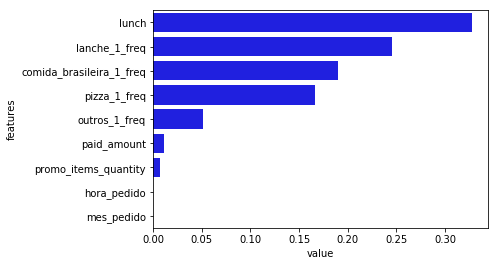

In [0]:
import seaborn as sns
pdImportance = pd.DataFrame(dc.featureImportances.toArray()).transpose()
pdImportance.columns = treino.drop('merchant_dish_type','features','merchant_dish_type_index').columns
pdImportance= pdImportance.transpose().sort_values(by=0, ascending=False).reset_index().rename(columns={'index':'features',0:'value'})
sns.barplot(x='value',y='features', data=pdImportance, color="b")